# Molecular Dynamics

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import plotly.express as px

!["Cu atoms"](https://upload.wikimedia.org/wikipedia/commons/4/42/Cudeposition.gif)

!["Water molecules"](https://upload.wikimedia.org/wikipedia/commons/f/f4/MD_water.gif)

### Is MD just Newton's laws applied on big systems?

**Not quite: Noble prize in Chemistry 2013 just for MD**

- Classical molecular dynamics (MD) is a powerful computational technique for studying complex molecular systems.
- Applications span wide range including proteins, polymers, inorganic and organic materials. 
- Alos molecular dynamics simulation is being used in a complimentary way to the analysis of experimental data coming from NMR, IR, UV spectroscopies and elastic-scattering techniques, such as small angle scattering or diffraction.

- [2013 Noble Lectures by M Karplus, A Warshell, M Levitt](https://www.youtube.com/watch?v=NuaeD9xYBtY)

![](./figs/1466565515216.jpg)

### Timescales and Lengthscales

- Classical Molecular Dynamics can access a hiearrchy of time-scales from pico seconds to microseconds. 
- It is also possible to go beyond the time scale of brute force MD byb emplying clever enhanced sampling techniques.

![](./figs/md-timescales.png)

## Energy function (force fields) used in classical MD

### Non-bonded interactions: Van der Waals

In [29]:
@widgets.interact(sig=(1,2, 0.1),eps=(0.1,3))
def plot_lj(sig=1, eps=1):
    
    r  = np.linspace(0.5, 3, 1000)
    lj = 4 * eps *  ( (sig/r)**12 -(sig/r)**6 )
    
    plt.plot(r, lj, lw=3)
    plt.plot(r, -4*eps*(sig/r)**6, '-',lw=3)
    plt.plot(r,  4*eps*(sig/r)**12,'-',lw=3)

    plt.ylim([-3,3])
    plt.xlabel(r'$r$')
    plt.ylabel(r'$U(r)$')
    plt.legend(['LJ', 'Attr-LJ','Repuls-LJ' ])
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='sig', max=2.0, min=1.0), FloatSlider(value=1.0, desc…

In [36]:
@widgets.interact(kappa=(0.1,5))
def plot_lj(kappa=0.1):
    
    r    = np.linspace(1, 5, 1000)
    
    E_DH = np.exp(-kappa*r)/r

    plt.plot(r, E_DH, lw=3)

    plt.ylim([0,1])
    plt.legend(['Debye-Huckel potential'])
    plt.xlabel(r'$r$')
    plt.ylabel(r'$U(r)$')

    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=0.1, description='kappa', max=5.0, min=0.1), Output()), _dom_classes=(…

In [ ]:
@widgets.interact(kappa=(0.1,5))
def plot_harmonic(k=0.1):
    
    r    = np.linspace(1, 5, 1000)

    plt.grid(True)
    plt.show()

## Integrating equations of motion

### No thanks, Euler
The simplest integrating scheme for ODEs is the Euler's method. Given the $n$-dimensional vectors from the ODE standard form. the **Euler rule** amounts to writing down equation in finite difference form.

$$
\frac{d {y}}{dt} = {f}(t, {y})
$$

$$\frac{d y(t)}{dt} \approx \frac{{y}(t_{n+1}) - {y}(t_n)}{h}$$

$${y}_{n+1} \approx {y}_n + h {f}(t_n, {y}_n)$$


**Much better integrators are known under the names of Runge Kutta, 2nd, 4th, 6th ... order**

In [67]:
def euler(y, f, t, h):   
    """Euler integrator: Returns new y at t+h.
    """
    return y + h * f(t, y)

def rk2(y, f, t, h):
    """Runge-Kutta RK2 midpoint"""
    
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    
    return y + h*k2

def rk4(y, f, t, h):
    """Runge-Kutta RK4"""
    
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    k3 = f(t + 0.5*h, y + 0.5*h*k2)
    k4 = f(t + h, y + h*k3)
    
    return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)

### Verlet algortihm

Taylor expansion of position $\vec{r}(t)$ after timestep $\Delta t$ we obtain forward and backward Euler schems

$$r_{t+\Delta t} = r_t +v_t\Delta t +\frac{1}{2}a_t \Delta t^2 + O(\Delta t^3)$$

$$r_{t-\Delta t} = r_t -v_t \Delta t +\frac{1}{2}a_t \Delta t^2 + O(\Delta t^3)$$

- In 1967 Loup Verlet introduced a new algorithm into molecular dynamics simulations which preserves energy is accurate and efficient.

- Summing the two taylor expansion above we get a updating scheme which is an order of mangnitude more accurate

$$r_{t+\Delta t} = 2r_t - r_{t-\Delta t} +a_t \Delta t^2+O(\Delta t^4)$$

$$v_t = \frac{r_{t+\Delta t}-r_{t-\Delta t}}{2\Delta t} +O(\Delta t^2) $$

- Velocity is not needed to update the positions. But we still need them to set the temperature. 

- Terms of order $O(\Delta t^3)$ cancel in position giving position an accuracy of order $O(\Delta t^4)$

- To update the position we need positions in the past at two different time points! This is is not very efficient.

### Velocity Verlet updating scheme

- A better updating scheme has been proposed known as **Velocity-Verlet (VV)** which stores **positions, velocities and accelerations at the same time.** Time stepping backward expansion $r(t-\Delta t + \Delta t)$ and summing with the forward Tayloer expansions we get Velocity Verlet updating scheme:

$$v_{t+\Delta t} = v_t + \frac{1}{2}(a_t+a_{t+\Delta t})\Delta t +O(\Delta t^3)$$

Substituting forces $a=\frac{F}{m}$ instead of acelration we get 

$$r_{t+\Delta t} = r_t + v_t\Delta t + \frac{F_t}{2m}\Delta t^2$$


$$v_{t+\Delta t} = v_t + \frac{F_t+F_{t+\Delta t}}{2m}\Delta t$$

### Velocity Verlet  Algorithm

**1. Evaluate the forces by plugging initial positions into force-field**

$$F_t \leftarrow - \frac{\partial U(r)}{ \partial r}\Big |_{r(t)} $$

**2. Position update:**

$$r_{t+\Delta t}  = r_t +v \Delta t + \frac{F_t}{2m}\Delta t^2$$


**3. Partial update of velocity**

$$v  \leftarrow v +  \frac{F_t}{2m} \Delta t$$

**3. Force/acceleration evalutation at a new position**

$$F_{t+\Delta t} = -\frac{\partial U(r)}{\partial r}\Big |_{r(t+\Delta t)}$$

**4. Full update of velocity**

$$v  \leftarrow v +  \frac{F_{t+\Delta t}}{2m} \Delta t$$

#### Alternative implementaitons of VV

- There is an identical to Velocity Verlet integration scheme known as **the Leapfrog algorithm.** which differens in the way of implementation.
- In the Leap-frog velocities are calculated at half-timestep $\Delta t/2$.

$$v_{t+\Delta t/2} = v_{t-\Delta t/2} + \frac{F_t}{2m}\Delta t$$

$$r_{t+\Delta t} = r_t + v_{t+\Delta t/2}\Delta t$$


- One disadvantage of the leap frog approach is that the velocities are not known at the same time as the positions, making it difficult to evaluate the total energy (kinetic + potential) at any one point in time.

In [124]:
def velv(y, f, t, h):
    """Velocity Verlet for solving differential equations. 
    A little inefficient since same force (first and last) is evaluated twice!
    """
    
    # 1. Evluate force
    F = f(t, y)
    
    # 2, Velocity partial update
    y[1] += 0.5*h * F[1]

    # 3. Full step position
    y[0] += h*y[1]
    
    # 4. Force re-eval
    F = f(t+h, y)
    
    # 5. Full step velocity 
    y[1] += 0.5*h * F[1]  

    return y

### Comparison of RK and Verlet

In [57]:
def f(t, y):
    ''' Define a simple harmonic potential'''
    
    return np.array([y[1], -y[0]])

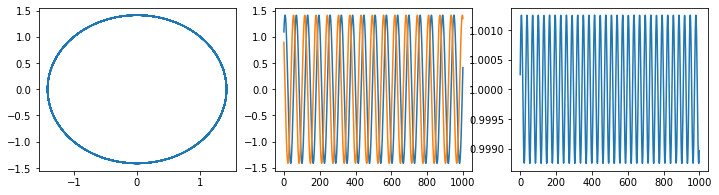

In [155]:
y  = np.array([1., 1.])
pos, vel = [], []
t  = 0
h = 0.1 

for i in range(1000):
    
    y = velv(y, f, t, h) # Change integration method venv, euler, rk2, rk4
    
    t+=h
    
    pos.append(y[0])
    vel.append(y[1])

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))

pos, vel =np.array(pos), np.array(vel)
ax[0].plot(pos, vel)
ax[1].plot(pos)
ax[1].plot(vel)
ax[2].plot(0.5*pos**2 + 0.5*vel**2)

# Ensemble averages

### Ensemble vs time average and ergodicity

$$\langle A \rangle  = \frac{1}{T_{prod}} \int^{T_{eq} +T_{prod}}_{T_{eq}} A(t)$$

### Kinetic, Potential and Total Energies

- Kinetic, potential and total energies are flcutuation quantities in the Molecualr dynamics simulations.

- Energy conservation should still hold: The mean of total energy should be stable

$$KE_t = \sum_i \frac{p_t^2}{2m}$$

$$PE_t = \sum_{ij}u_{ij}(r_t)$$

$$\langle E \rangle = \langle KE \rangle +\langle PE \rangle \approx const $$

### Temperature

According to equipariting result of equilibrium statistical mechanics in the NVT ensmeble

$$\Big\langle \sum_i \frac{p_t^2}{2m} \Big\rangle =\frac{3 }{2}N  k_B T$$


$$T_t = \frac{2}{3 N k_B} \big\langle KE \big\rangle_t $$

### Pressure

The microscopic expression for the pressure can be derived in the NVE ensemble using  

$$P = \frac{1}{3V} \sum^N_i \Big [\frac{p^2_i}{m} +\vec{F}_i(r) \cdot \vec{r}_i(t) \Big ]$$

## Molecular Dynaamics of Classical Harmonic Oscillator

### NVE

In [158]:
def time_step_1D(pos, vel, F, en_force):
    '''Velocity Verlet update of velocities, positions and forces
    pos         (float):      position
    vel         (float):      velocity
    F           (float):        force
    en_force (function): a function whichb computes potential energy and force (derivative)
    '''
    
    vel   += 0.5 * F * dt
    
    pos   += vel * dt
    
    pe, F  = en_force(pos)
    
    vel   += 0.5 * F * dt

    return pos, vel, F, pe

In [159]:
def md_nve_1d(x, v, dt, t_max, en_force):
    '''Minimalistic MD code applied to a harmonic oscillator'''
    
    times, pos, vel, KE, PE  = [], [], [], [], []
    
    #1. Intialize force
    pe, F = en_force(x) 
    
    for step in range(int(t_max/dt)):
        
        x, v, F, pe = time_step_1D(x, v, F, en_force)
        
        pos.append(x), vel.append(v), KE.append(0.5*v*v), PE.append(pe)    
    
    return np.array(pos), np.array(vel), np.array(KE), np.array(PE)

In [179]:
#----parameters of simulation----
k     = 3 
x0    = 1 
v0    = 0
dt    = 0.01 * 2*np.pi/np.sqrt(k) #A good timestep determined by using oscillator frequency
t_max = 1000

def ho_en_force(x, k=k):
    '''Force field of harmonic oscillator:
    returns potential energy and force'''
    
    return k*x**2, -k*x

In [180]:
pos, vel, KE, PE = md_nve_1d(x0, v0, dt, t_max, ho_en_force)

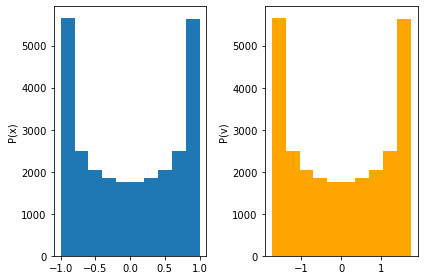

In [181]:
fig, ax =plt.subplots(ncols=2)

ax[0].hist(pos);
ax[1].hist(vel, color='orange');
ax[0].set_ylabel('P(x)')
ax[1].set_ylabel('P(v)')

fig.tight_layout()

### Molecualr Dynamics of Harmonic oscillator (NVT)

**Newton's equation of motion**

$$F =  m \ddot{x} = -\nabla_x U$$

**Langevin equation**

$$F =  -\nabla_x U - \lambda \dot{x} + \eta(t)$$

**Overdamped Langevin equation,  $m\dot{v} =0$**

$$ \lambda \dot{x} = \nabla_x U + \eta(t)$$

**Fluctuation-dissipation theorem**

$$\langle \eta(t) \eta(t') \rangle = 2\lambda k_B T \delta(t-t')$$

**Velocity updating when coupled to a thermal heat bath**

$$ v_{t+\Delta t} = v_t e^{-\lambda  \Delta t} + (k_B T)^{1/2} \cdot (1-e^{-2\gamma \Delta t})^{1/2}  \cdot N(0,1)$$

In [197]:
def langevin_md_1d(x, v, dt, kBT, gamma, t_max, en_force):
    '''Langevin dynamics applied to 1D potentials
    Using integration scheme known as BA-O-AB.
    INPUT: Any 1D function with its parameters
    '''
    
    times, pos, vel, KE, PE  = [], [], [], [], []
    
    t = 0  
    for step in range(int(t_max/dt)):
        
        #B-step
        pe, F = en_force(x)
        v    += F*dt/2
        
        #A-step
        x += v*dt/2

        #O-step
        v = v*np.exp(-gamma*dt) + np.sqrt(1-np.exp(-2*gamma*dt)) * np.sqrt(kBT) * normal()
        
        #A-step
        x +=  v*dt/2
        
        #B-step
        pe, F = en_force(x)
        v    +=  F*dt/2
        
        ### Save output 
        times.append(t), pos.append(x), vel.append(v), KE.append(0.5*v*v), PE.append(pe)    
    
    return np.array(times), np.array(pos), np.array(vel), np.array(KE), np.array(PE)

In [198]:
# Ininital conditions
x     = 0.1
v     = 0.5

# Input parameters of simulation
kBT   = 0.25
gamma = 10
dt    = 0.01
t_max = 10000
freq  = 10

times, pos, vel, KE, PE = langevin_md_1d(x, v, dt, kBT, gamma, t_max, ho_en_force)

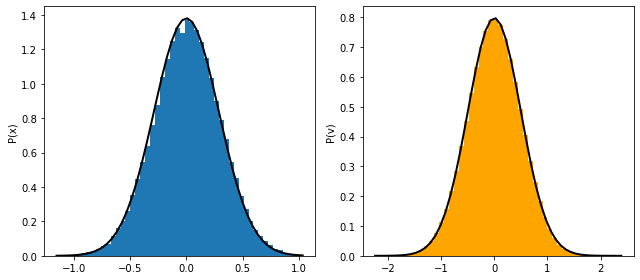

In [205]:
def gaussian_x(x, k, kBT): 
    return  np.exp(-k*(x**2)/(2*kBT)) / np.sqrt(2*np.pi*kBT/k)
    
def gaussian_v(v, kBT):   
    return  np.exp(-(v**2)/(2*kBT))  / np.sqrt(2*np.pi*kBT) 

fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(9,4))

bins=50

x = np.linspace(min(pos), max(pos), bins)
ax[0].hist(pos, bins=bins, density=True) 
ax[0].plot(x, gaussian_x(x, k, kBT), lw=2, color='k')

v = np.linspace(min(vel), max(vel), bins)
ax[1].hist(vel, bins=bins, density=True, color='orange') 
ax[1].plot(v, gaussian_v(v, kBT), lw=2, color='k')

ax[0].set_ylabel('P(x)')
ax[1].set_ylabel('P(v)')

fig.tight_layout()

### Double well potential

In [206]:
def double_well(x, k=1, a=3):
    
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    
    return energy, force

@widgets.interact(k=(0.1, 1), a=(0.1,3))
def plot_harm_force(k=1, a=3):
    
    x = np.linspace(-6,6,1000)
    
    energy, force = double_well(x, k, a) 
    
    plt.plot(x, energy, '-o',lw=3)
    plt.plot(x, force, '-', lw=3, alpha=0.5)
    
    plt.ylim(-20,40)
    plt.grid(True)
    plt.legend(['$U(x)$', '$F=-\partial_x U(x)$'], fontsize=15)

interactive(children=(FloatSlider(value=1.0, description='k', max=1.0, min=0.1), FloatSlider(value=3.0, descri…

In [207]:
# Ininital conditions
x     = 0.1
v     = 0.5

# Input parameters of simulation
kBT   = 5 # vary this
gamma = 0.1 # vary this

dt    = 0.05
t_max = 10000
freq  = 10

times, pos, vel, KE, PE = langevin_md_1d(x, v, dt, kBT, gamma, t_max, double_well)

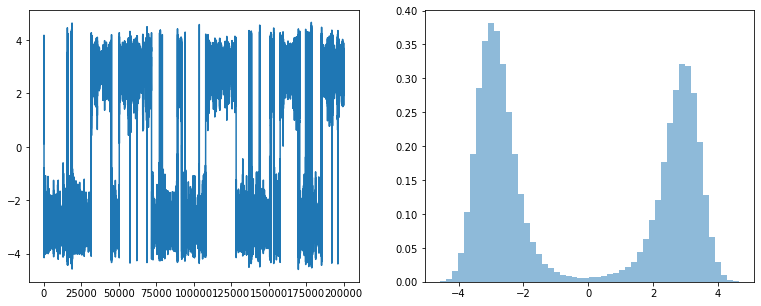

In [208]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(13,5))

x = np.linspace(min(pos), max(pos), 50)


ax[0].plot(pos)
ax[1].hist(pos, bins=50, density=True, alpha=0.5);

v = np.linspace(min(vel), max(vel),50)

### Additional resoruces for learning MD

For a quick dive consult the following lecture notes:

- [Goran Wahnstrom's MD and MC lectures](http://fy.chalmers.se/~tfsgw/CompPhys/)
- [Online course materials: **principles of modern molecular simulation methods**](https://sites.engineering.ucsb.edu/~shell/che210d/assignments.html)

The best resource for comprehensive stuyd remains the timeless classic by Daan Frankel

- ["Understanding Molecular Simulation: From Algorithms to Applications" a book by Daan Frankel](https://www.elsevier.com/books/understanding-molecular-simulation/frenkel/978-0-12-267351-1)

### Problems

#### 1D harmonic potential
Given a 1D potential $U(x)$ write code to carry out  molecular dynamics

$$U(x) = Ax^2 +B x^3 + C x^4$$

- Using langevin dynamics to simulate the system in NVT ensemble. 

- Your input should read in A, B, C parameters, starting point and velocity, timestep and number of iterations, kBT, gamma. 

- Output should be the positions which should then be histogrammed to obtain probability distribution

- Use A=-1, B = 0.0, C = 1.0. Try various initial positions.  Look for some interesting regions to sample by adjusting initital positions.  

- Use A=-1, B = -1, C = 1.0. Again try various initial strting positions.

#### Beads and springs

Simulate a chain of harmonic oscillators with the following potential energy function

$$U(x_1, x_2, ...) = \sum_j \frac{p^2_j}{2m} + \frac{1}{2} K \sum_j (x_j -x_{j-1})^2$$

- Take the particle at $x_0 = 0$ fixed. Carry out constant T MD using langevin dynamics 

- Try N = 2, N=10 particles and obtain equilibrium distributions of $x_{j}-x_{j-1}$ for various temperatures. 